In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import spacy
import spacy as displacy
import spacy as tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import gensim
import gensim.corpora as corpora 
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\INDIA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [183]:
#set plot options
plt.rcParams['figure.figsize']=(12,8)
default_plot_colour= "#00bfbf"

In [184]:
data=pd.read_csv("C:\\Users\\INDIA\\Downloads\\fake_news_data.csv")

In [185]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [186]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

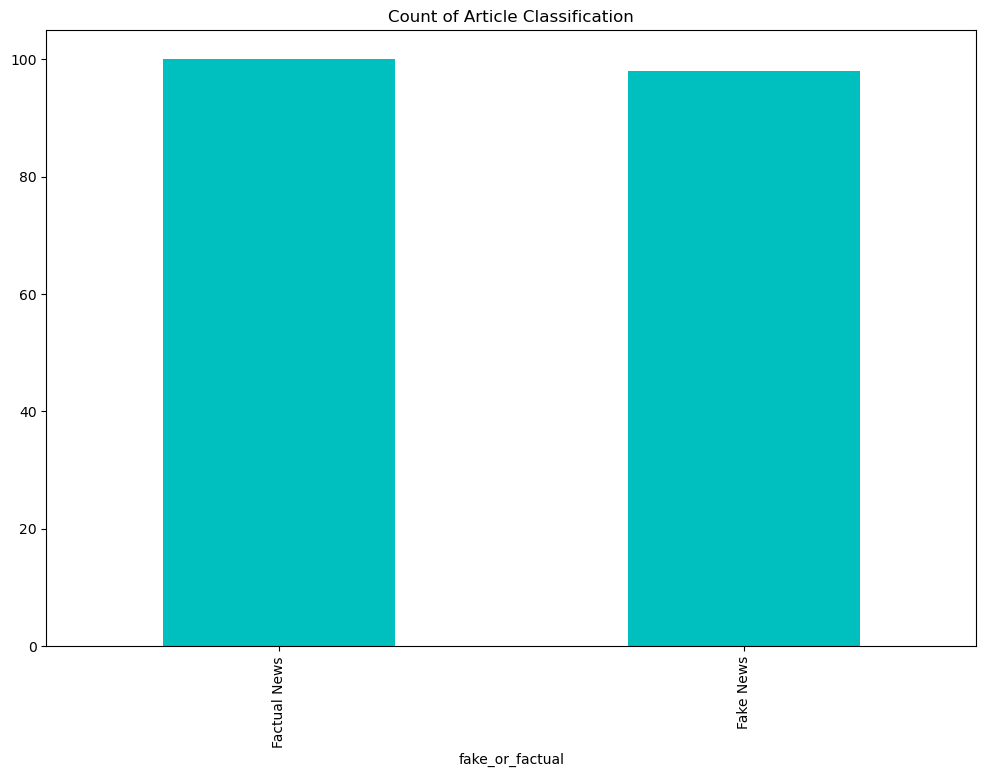

In [187]:
data['fake_or_factual'].value_counts().plot(kind='bar',color=default_plot_colour)
plt.title("Count of Article Classification")

In [194]:
nlp=spacy.load('en_core_web_sm')

In [195]:
fake_news=data[data['fake_or_factual'] == "Fake News"]  
fact_news=data[data['fake_or_factual'] == "Factual News"]  

In [196]:
fake_spacydocs=list(nlp.pipe(fake_news['text']))
fact_spacydoc=list(nlp.pipe(fact_news['text']))

In [197]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return[(i.text,i.ent_type_,i.pos_) for i in doc] 

In [198]:
fake_tagsdf=[]
columns=["token","ner_tag","pos_tag"]

In [199]:
for ix,doc in enumerate(fake_spacydocs):
    tags=extract_token_tags(doc)
    tags=pd.DataFrame(tags)
    tags.columns=columns
    fake_tagsdf.append(tags)

In [200]:
fake_tagsdf=pd.concat(fake_tagsdf)

In [201]:
fact_tagsdf=[]

for ix,doc in enumerate(fact_spacydoc):
    tags=extract_token_tags(doc)
    tags=pd.DataFrame(tags)
    tags.columns=columns
    fact_tagsdf.append(tags)

In [202]:
fact_tagsdf=pd.concat(fact_tagsdf)

In [203]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [204]:
pos_counts_fake=fake_tagsdf.groupby(["token","pos_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795
7523,to,PART,767
4915,in,ADP,667
5094,is,AUX,419


In [205]:
pos_counts_fact=fact_tagsdf.groupby(["token","pos_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672
6230,to,PART,660
4761,on,ADP,482
5586,said,VERB,452


In [206]:
pos_counts_fake.groupby("pos_tag")["token"].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2597
VERB     1814
PROPN    1657
ADJ       876
ADV       412
NUM       221
PRON       99
ADP        88
AUX        58
SCONJ      54
Name: token, dtype: int64

In [207]:
pos_counts_fact.groupby("pos_tag")["token"].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2182
VERB     1535
PROPN    1387
ADJ       753
ADV       271
NUM       203
PRON       81
ADP        70
AUX        44
SCONJ      39
Name: token, dtype: int64

In [208]:
pos_counts_fake[pos_counts_fake.pos_tag=="NOUN"][:15]

,token,pos_tag,counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
3134,campaign,NOUN,44
4577,government,NOUN,41
5208,law,NOUN,40
7344,t,NOUN,40
8013,years,NOUN,40


In [209]:
pos_counts_fact[pos_counts_fact.pos_tag=="NOUN"][:15]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
3289,election,NOUN,48
5084,president,NOUN,47
4804,order,NOUN,45
4937,people,NOUN,45
2509,campaign,NOUN,42


In [210]:
top_entities_fake=fake_tagsdf[fake_tagsdf["ner_tag"] !=""].groupby(["token","ner_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [211]:
top_entities_fact=fact_tagsdf[fact_tagsdf["ner_tag"] !=""].groupby(["token","ner_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [212]:
ner_palette={
    'ORG':sns.color_palette("Set2").as_hex()[0],
    'GPE':sns.color_palette("Set2").as_hex()[1],
    'NORP':sns.color_palette("Set2").as_hex()[2],
    'PERSON':sns.color_palette("Set2").as_hex()[3],
    'DATE':sns.color_palette("Set2").as_hex()[4],
    'CARDINAL':sns.color_palette("Set2").as_hex()[5],
    'PERCENT':sns.color_palette("Set2").as_hex()[6],
    
}

[Text(0.5, 1.0, 'Most Common Named Entities in Fake News')]

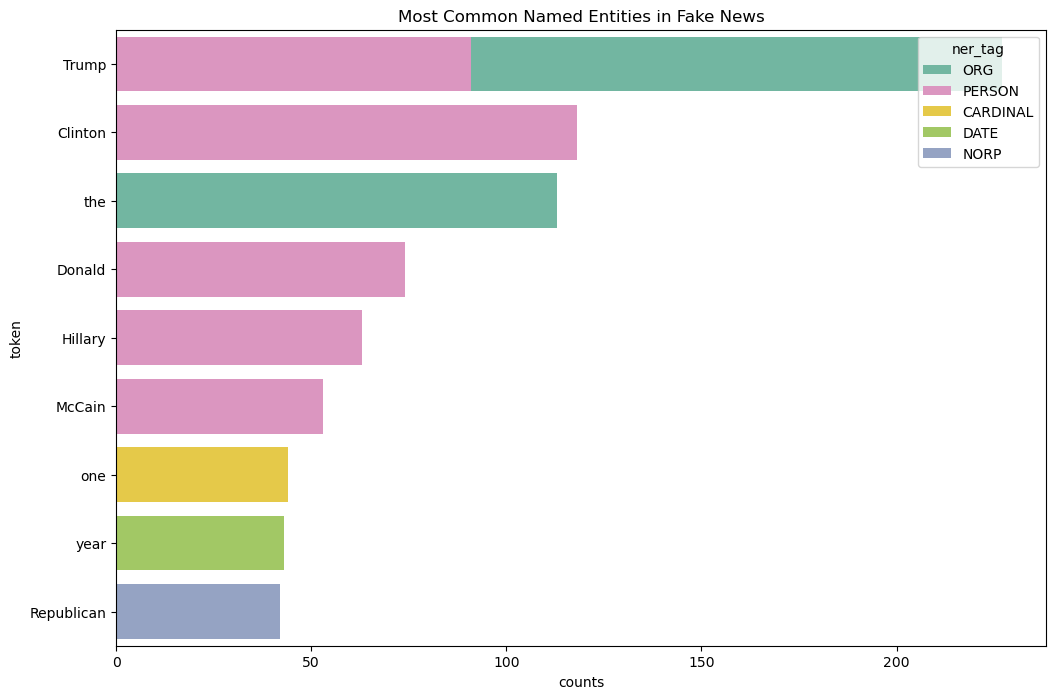

In [213]:
sns.barplot(
    x='counts',
    y='token',
    hue='ner_tag',
    palette=ner_palette,
    data=top_entities_fake[:10],
    orient='h',
    dodge=False
).set(title="Most Common Named Entities in Fake News")

[Text(0.5, 1.0, 'Most Common Named Entities in Factual News')]

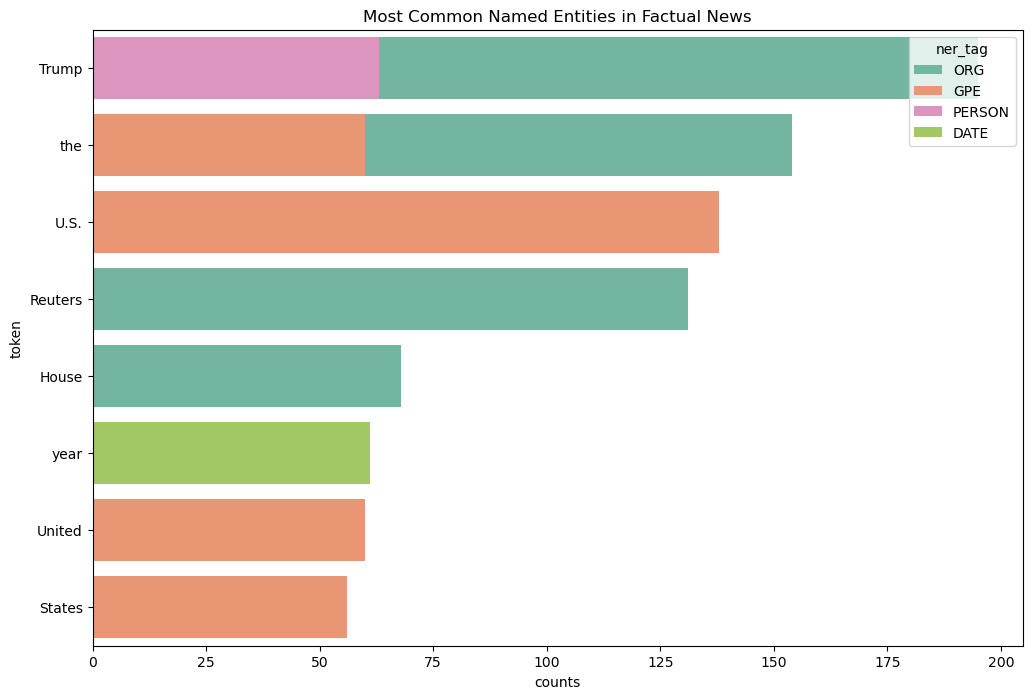

In [214]:
sns.barplot(
    x='counts',
    y='token',
    hue='ner_tag',
    palette=ner_palette,
    data=top_entities_fact[:10],
    orient='h',
    dodge=False
).set(title="Most Common Named Entities in Factual News")

In [215]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [216]:
data['text_clean']=data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x['text']), axis=1)

In [217]:
data['text_clean']=data['text_clean'].str.lower()

In [218]:
data['text_clean']=data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)

In [219]:
en_stopwords=stopwords.words('english')
print(en_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [220]:
data['text_clean']=data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in(en_stopwords)]))

In [221]:
data['text_clean']=data.apply(lambda x: word_tokenize(x['text_clean']),axis=1)

In [222]:
lemmatizer=WordNetLemmatizer()
data['text_clean']=data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [223]:
tokens_clean=sum(data['text_clean'], [])

In [224]:
unigrams=(pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts())
print(unigrams[:10])

(trump,)         580
(said,)          580
(u,)             277
(state,)         275
(president,)     259
(would,)         226
(one,)           160
(clinton,)       141
(year,)          139
(republican,)    137
Name: count, dtype: int64


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

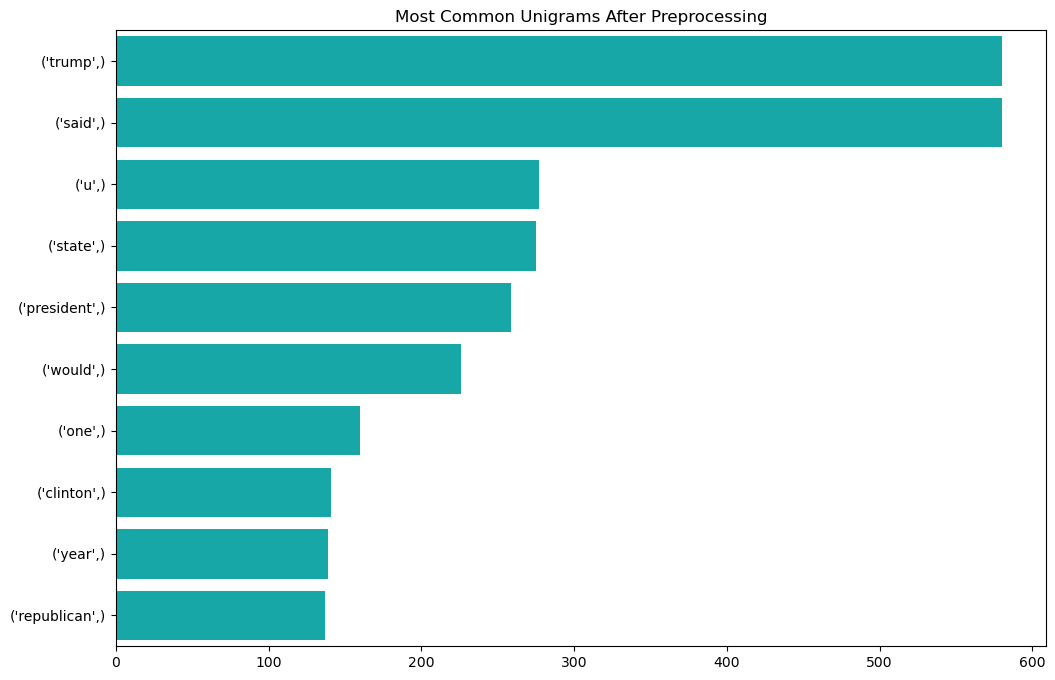

In [225]:
sns.barplot(x=unigrams.values[:10],
            y=unigrams.index[:10],
            orient='h',
            palette=[default_plot_colour]
).set(title="Most Common Unigrams After Preprocessing")

In [226]:
bigrams=(pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts())
print(bigrams[:10])

(donald, trump)            113
(united, state)             84
(white, house)              74
(president, donald)         47
(hillary, clinton)          39
(new, york)                 33
(supreme, court)            30
(image, via)                29
(official, said)            26
(trump, administration)     26
Name: count, dtype: int64


In [227]:
vader_sentiment=SentimentIntensityAnalyzer()

In [228]:
data['vader_sentiment_score']=data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [229]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.7973
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9886
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [230]:
bins=[-1,-0.1,0.1,1]
names=['negative','neutral','positive']

In [231]:
data['vader_sentiment_label']=pd.cut(data['vader_sentiment_score'],bins,labels=names)

In [232]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.7973,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9886,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

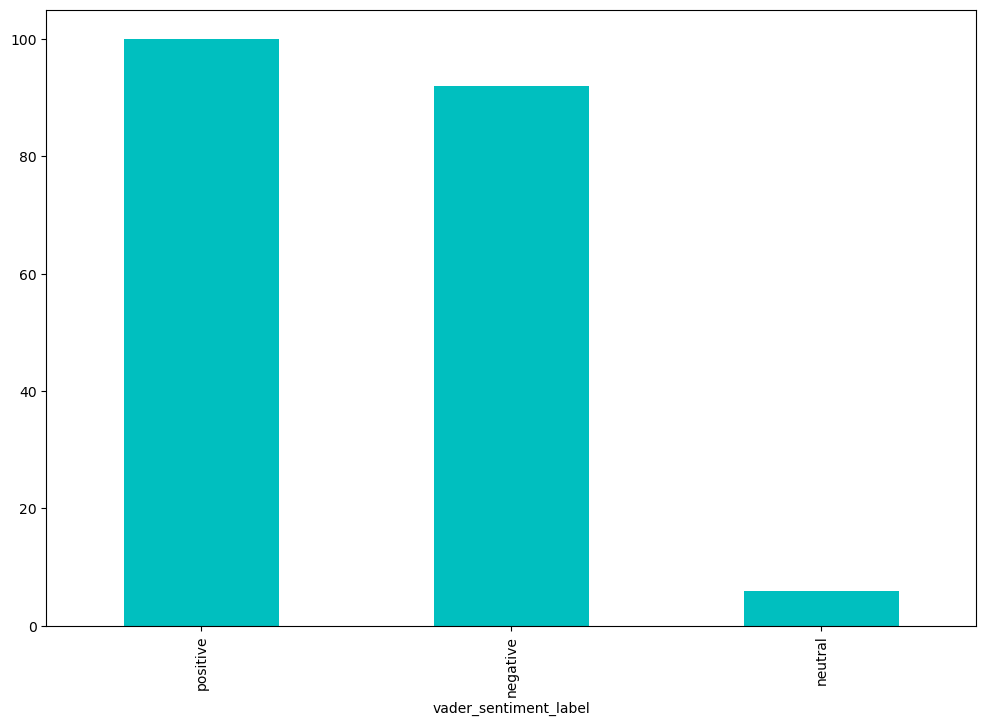

In [233]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

[Text(0.5, 1.0, 'Sentiment by News Type')]

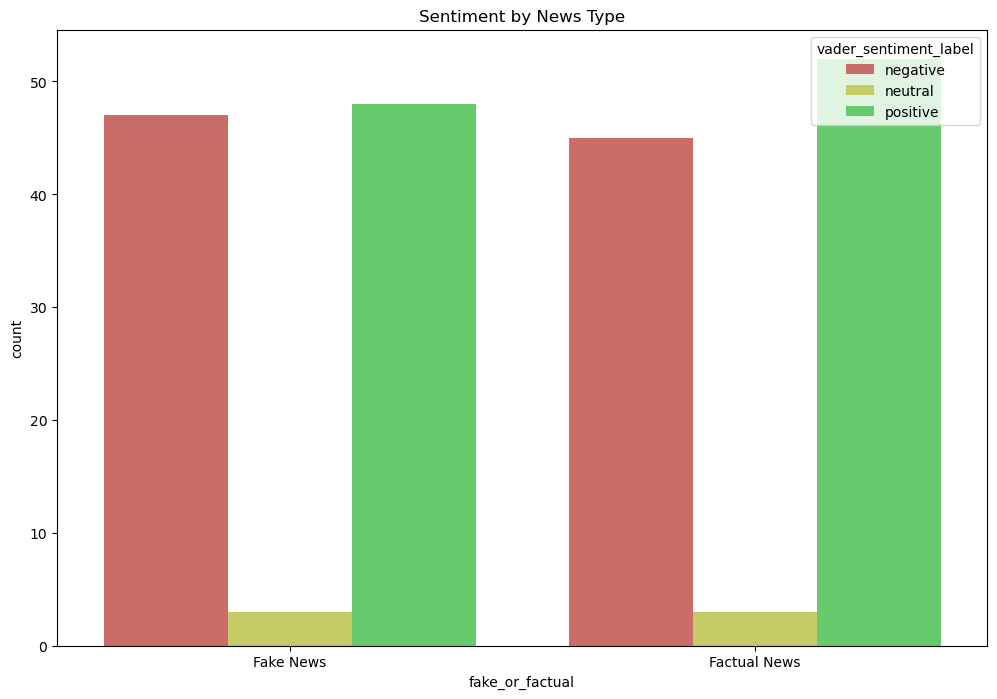

In [234]:
sns.countplot(
    x='fake_or_factual',
    hue='vader_sentiment_label',
    palette=sns.color_palette("hls"),
    data=data
).set(title="Sentiment by News Type")

In [235]:
 fake_news_text=data[data['fake_or_factual']=="Fake News"] ['text_clean'].reset_index(drop=True)

In [236]:
dictionary_fake=corpora.Dictionary(fake_news_text)

In [242]:
doc_term_fake=[dictionary_fake.doc2bow(text) for text in fake_news_text]

In [243]:
coherence_values=[]
model_list=[]

min_topics=2
max_topics=11

for num_topics_i in range(min_topics,max_topics+1):
    model=gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word=dictionary_fake)
    model_list.append(model)
    coherence_model=CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

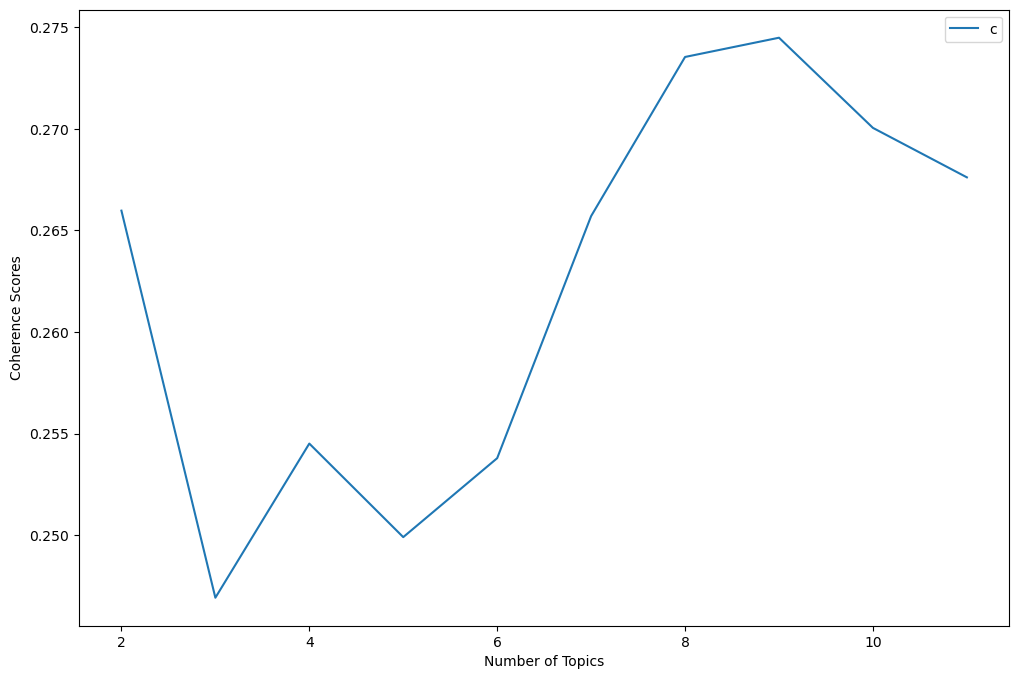

In [244]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [245]:
num_topics_lda=7
lda_model=gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_lda)

In [246]:
lda_model.print_topics(num_topics_lda, num_words=10)

[(0,
  '0.006*"clinton" + 0.005*"said" + 0.005*"state" + 0.005*"trump" + 0.004*"u" + 0.004*"obama" + 0.004*"stamp" + 0.004*"president" + 0.003*"food" + 0.003*"go"'),
 (1,
  '0.007*"trump" + 0.005*"would" + 0.005*"president" + 0.004*"clinton" + 0.004*"one" + 0.004*"said" + 0.004*"state" + 0.003*"republican" + 0.003*"year" + 0.003*"people"'),
 (2,
  '0.011*"trump" + 0.006*"president" + 0.006*"said" + 0.005*"donald" + 0.005*"u" + 0.003*"state" + 0.003*"time" + 0.003*"one" + 0.003*"would" + 0.003*"know"'),
 (3,
  '0.011*"trump" + 0.005*"u" + 0.005*"clinton" + 0.004*"president" + 0.003*"state" + 0.003*"woman" + 0.003*"said" + 0.003*"would" + 0.003*"year" + 0.003*"donald"'),
 (4,
  '0.024*"trump" + 0.005*"said" + 0.004*"time" + 0.004*"republican" + 0.004*"state" + 0.003*"president" + 0.003*"one" + 0.003*"would" + 0.003*"even" + 0.003*"donald"'),
 (5,
  '0.009*"trump" + 0.005*"president" + 0.005*"state" + 0.004*"mccain" + 0.004*"one" + 0.004*"would" + 0.004*"time" + 0.004*"clinton" + 0.003*"s

In [247]:
def tfidf_corpus(doc_term_matrix):
    tfidf= TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf=tfidf[doc_term_matrix]
    return corpus_tfidf

In [248]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values=[]
    model_list=[]
    for num_topics_i in range(min_topics,max_topics+1):
        model=LsiModel(corpus, num_topics=num_topics_i, id2word=dictionary)
        model_list.append(model)
        coherence_model=CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Scores")
    plt.legend(("coherence_values"), loc='best')
    plt.show()        

In [249]:
corpus_tfidf_fake= tfidf_corpus(doc_term_fake)

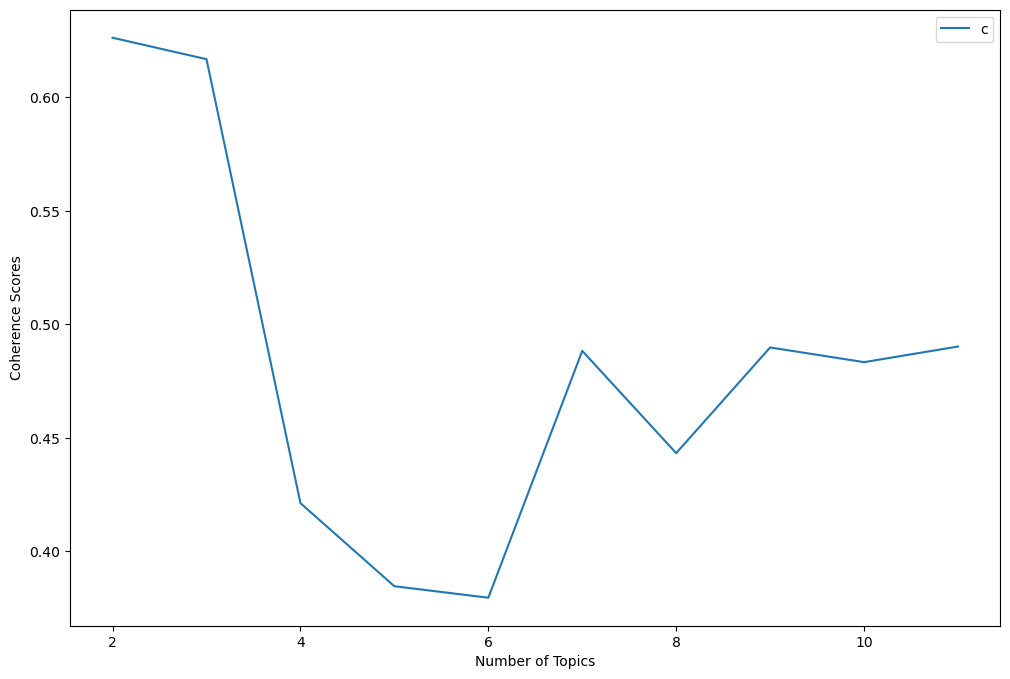

In [250]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [251]:
lsa_model= LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=7)

In [252]:
lsa_model.print_topics()

[(0,
  '-0.190*"trump" + -0.136*"clinton" + -0.095*"hillary" + -0.094*"obama" + -0.089*"president" + -0.087*"woman" + -0.078*"republican" + -0.077*"party" + -0.077*"flynn" + -0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"animal" + -0.142*"tune" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '-0.622*"flynn" + -0.182*"immunity" + -0.122*"nana" + -0.116*"mr" + -0.110*"30" + -0.108*"march" + -0.102*"russian" + -0.100*"source" + 0.095*"school" + -0.092*"adviser"'),
 (3,
  '0.217*"clinton" + -0.185*"school" + -0.175*"student" + 0.141*"hillary" + -0.122*"flynn" + -0.121*"county" + 0.110*"sander" + 0.097*"debate" + 0.097*"woman" + 0.091*"nominee"'),
 (4,
  '0.200*"email" + -0.194*"trump" + 0.168*"dnc" + -0.143*"flynn" + 0.126*"clinton" + -0.112*"cruz" + 0.111*"department" + 0.110*"rich" + 0.102*"wikileaks" + 0.099*"sander"'),
 (5,
  '-0.276*"student" + -0.162*"conference" + -0.160*"school" + -0.138*"trump"

In [253]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.7973,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9886,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [254]:
X= [','.join(map(str,l)) for l in data['text_clean']]

In [255]:
Y=data['fake_or_factual']

In [256]:
countvec= CountVectorizer()

In [257]:
countvec_fit= countvec.fit_transform(X)

In [258]:
bag_of_words=pd.DataFrame(countvec_fit.toarray(), columns=countvec.get_feature_names_out())

In [259]:
X_train, X_test, y_train, y_test= train_test_split(bag_of_words, Y, test_size=0.3)

In [260]:
lr= LogisticRegression(random_state=0).fit(X_train, y_train)

In [261]:
y_pred_lr= lr.predict(X_test)

In [262]:
accuracy_score(y_pred_lr, y_test)

0.95

In [263]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.96      0.93      0.95        29
   Fake News       0.94      0.97      0.95        31

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



In [264]:
svm= SGDClassifier().fit(X_train, y_train)

In [265]:
y_pred_svm= svm.predict(X_test)

In [266]:
accuracy_score(y_pred_svm, y_test)

0.9333333333333333

In [267]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       1.00      0.86      0.93        29
   Fake News       0.89      1.00      0.94        31

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60

